In [5]:
import math
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np

# Your tags
TAGS = [
    "Episode_Reward/robot_vel_reward",
    "Total_Reward",
    "agent0/policy_loss",
    "agent0/dist_entropy",
    "agent0/actor_grad_norm",
    "agent0/ratio",
    "critic/value_loss",
    "critic/critic_grad_norm",
    "critic/average_step_rewards",
]

# Nice titles for each plot
PRETTY_TITLES = {
    "Episode_Reward/robot_vel_reward": "Episode Reward – Robot Velocity Component",
    "Total_Reward": "Total Episode Reward",
    "agent0/policy_loss": "Agent 0 – Policy Loss",
    "agent0/dist_entropy": "Agent 0 – Policy Entropy",
    "agent0/actor_grad_norm": "Agent 0 – Actor Gradient Norm",
    "agent0/ratio": "Agent 0 – PPO Policy Ratio",
    "critic/value_loss": "Critic – Value Loss",
    "critic/critic_grad_norm": "Critic – Gradient Norm",
    "critic/average_step_rewards": "Critic – Average Step Rewards",
}

# Optional: nicer y-labels (fallback to tag if not in dict)
YLABELS = {
    "Episode_Reward/robot_vel_reward": "Reward",
    "Total_Reward": "Reward",
    "agent0/policy_loss": "Loss",
    "agent0/dist_entropy": "Entropy",
    "agent0/actor_grad_norm": "Grad Norm",
    "agent0/ratio": "Ratio",
    "critic/value_loss": "Loss",
    "critic/critic_grad_norm": "Grad Norm",
    "critic/average_step_rewards": "Reward / Step",
}


def _smooth(values, window=10):
    """Simple moving average smoothing."""
    if window <= 1 or len(values) <= window:
        return values
    kernel = np.ones(window) / window
    return np.convolve(values, kernel, mode="valid")


def plot_all_scalars_from_run(
    logdir: str,
    tags=TAGS,
    smooth_window: int = 10,
):
    """
    Plot all specified scalar tags from a single TensorBoard run directory.

    Args:
        logdir: Path to the run directory (where events.out.tfevents.* lives).
        tags: List of scalar tags to plot.
        smooth_window: Moving average window for smoothing (set to 1 to disable).
    """
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={event_accumulator.SCALARS: 0},  # load all scalar data
    )
    ea.Reload()

    available = set(ea.Tags().get("scalars", []))
    tags_to_plot = [t for t in tags if t in available]

    if not tags_to_plot:
        print("No requested tags found in this logdir.")
        print("Available scalar tags:", sorted(available))
        return

    n = len(tags_to_plot)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(6 * ncols, 3.5 * nrows),
        squeeze=False,
    )

    for ax, tag in zip(axes.flatten(), tags_to_plot):
        events = ea.Scalars(tag)
        steps = np.array([e.step for e in events], dtype=float)
        values = np.array([e.value for e in events], dtype=float)

        # Optional smoothing
        if smooth_window > 1 and len(values) > smooth_window:
            values_smooth = _smooth(values, window=smooth_window)
            # align steps to the smoothed series length
            steps_smooth = steps[ (len(steps) - len(values_smooth)) : ]
            ax.plot(steps_smooth, values_smooth, linewidth=1.5)
        else:
            ax.plot(steps, values, linewidth=1.5)

        ax.set_title(PRETTY_TITLES.get(tag, tag), fontsize=11)
        ax.set_xlabel("Step")
        ax.set_ylabel(YLABELS.get(tag, "Value"))
        ax.grid(True, linestyle="--", alpha=0.4)

    # Hide any unused axes
    for ax in axes.flatten()[len(tags_to_plot):]:
        ax.axis("off")

    fig.suptitle(f"Training Metrics from {logdir}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


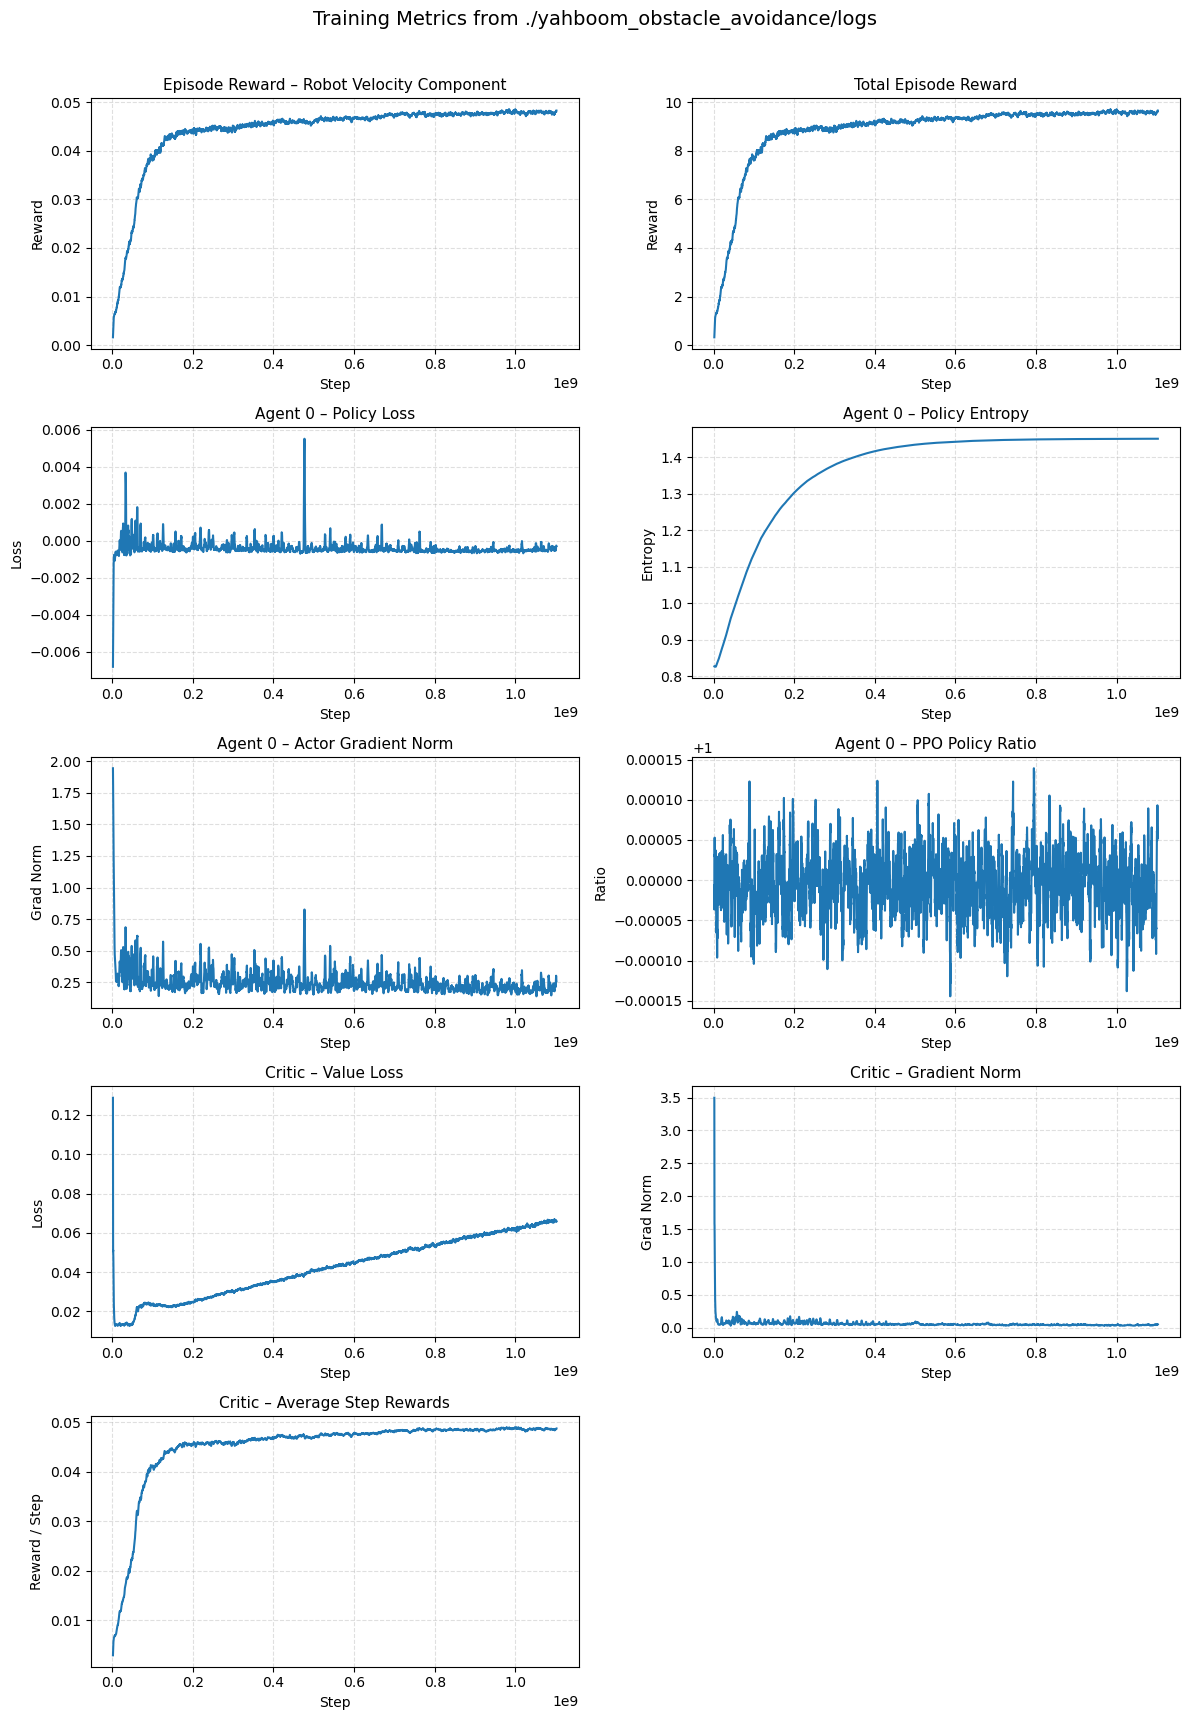

In [6]:
plot_all_scalars_from_run("./yahboom_obstacle_avoidance/logs")